In [1]:
import numpy as np
import os
import pickle
from utilities_ketamine_analysis_v8 import *
from utils_signal_processing import *
from utils_plotting import *
from utils_general import *
from scipy.signal import morlet, welch, convolve
import mne
import pywt

#### Function to extract instantaneous phase from Morlet Wavelet

In [2]:
def get_instantaneous_phase(lfp_signal, frequencies):
    T, nch = lfp_signal.shape
    phase_data = np.zeros((len(frequencies), T, nch))
    wavelist = []
    for f_idx, freq in enumerate(frequencies):
        wavelet = morlet(M=T, w=2*np.pi*freq, s=1, complete=True)
        wavelist.append(wavelet)
        for ch in range(nch):
            convolution = np.convolve(lfp_signal[:, ch], wavelet, 'same')
            phase_data[f_idx, :, ch] = np.angle(convolution)
    
    return phase_data, wavelist 

In [3]:
def get_phase_single_value(lfp_signal, freq):
    T = lfp_signal.size
    # wavelet = morlet(M=T, w=2*np.pi*freq, s=1, complete=True)
    wavelet = morlet(M=T, w=1/freq, s=1, complete=True)
    convolution = np.convolve(lfp_signal, wavelet, 'same')
    phase_data = np.angle(convolution)
    
    return phase_data, wavelet

In [4]:
# # Define the parameters for the signal generation
# frequency = 4  # Frequency of the sinusoidal function in Hz
# T = 1  # Time length of the signal in seconds
# sampling_rate = 1000  # Sampling rate in Hz

# # Generate the time vector
# t = np.linspace(0, T, int(T * sampling_rate), endpoint=False)
# # Generate the sinusoidal signal
# signal = np.sin(2 * np.pi * frequency * t)

# # Plot the signal
# plt.figure(figsize=(15, 4))
# plt.plot(signal)
# plt.title(f'Sinusoidal Signal at {frequency} Hz over {T} seconds')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.show()

In [235]:
# phase_data, wavelet = get_phase_single_value(signal, frequency)
# phase_data.shape, len(wavelet), wavelet[0].shape

((1000,), 1000, ())

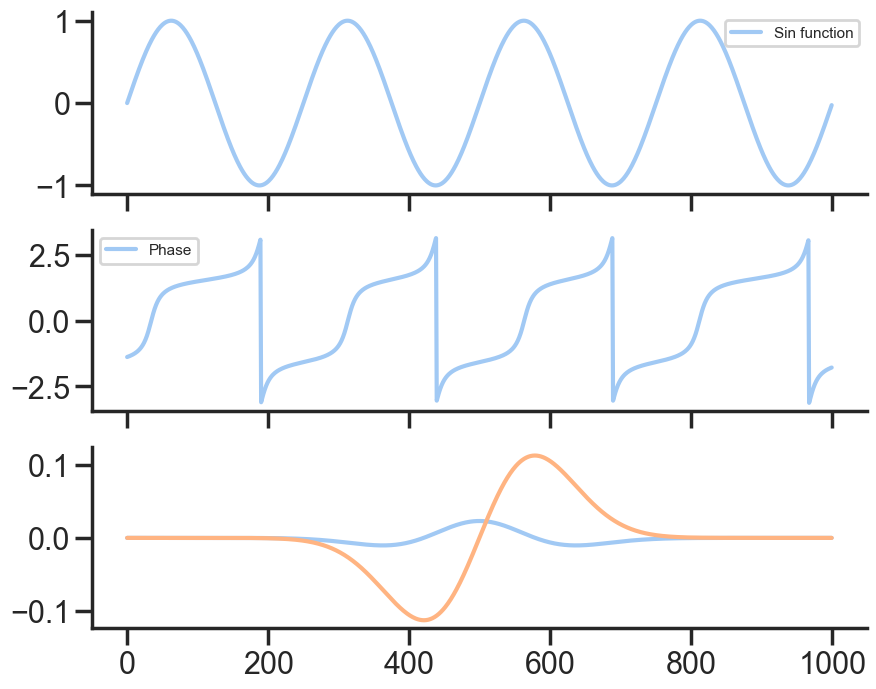

In [236]:
# First plot

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)  # Share x-axis
fig.set_size_inches(10, 8)

ax1.plot(signal)
ax1.legend(['Sin function'], fontsize=11)
# xticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# xlabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$']
# plt.xticks(xticks, xlabels)  # Set y-ticks and y-labels
# ax1.set_xlim([0, 500])

ax2.plot(phase_data)
ax2.legend(['Phase'], fontsize=11)
# ax2.set_title('Instantaneous phase vs time at given freq', fontsize=14)
yticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
ylabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$']
# ax2.yticks(yticks, ylabels)  # Set y-ticks and y-labels
# ax2.set_xlim([0, 500])


# Second plot
ax3.plot(wavelet.real, label='real')
ax3.plot(wavelet.imag, label='imag')
# plt.legend(fontsize=11)
# plt.title('Morlet transform for Sin function', fontsize=14)
plt.show()

In [239]:
# Constants
fs = 1000  # Sampling frequency in Hz
f = 4  # Frequency of the sin function in Hz
T = 1 / f  # Period of the sin function
N = int(8 * T * fs)  # Number of time points for 4 full oscillations

# Time vector for N time points
t = np.arange(N) / fs

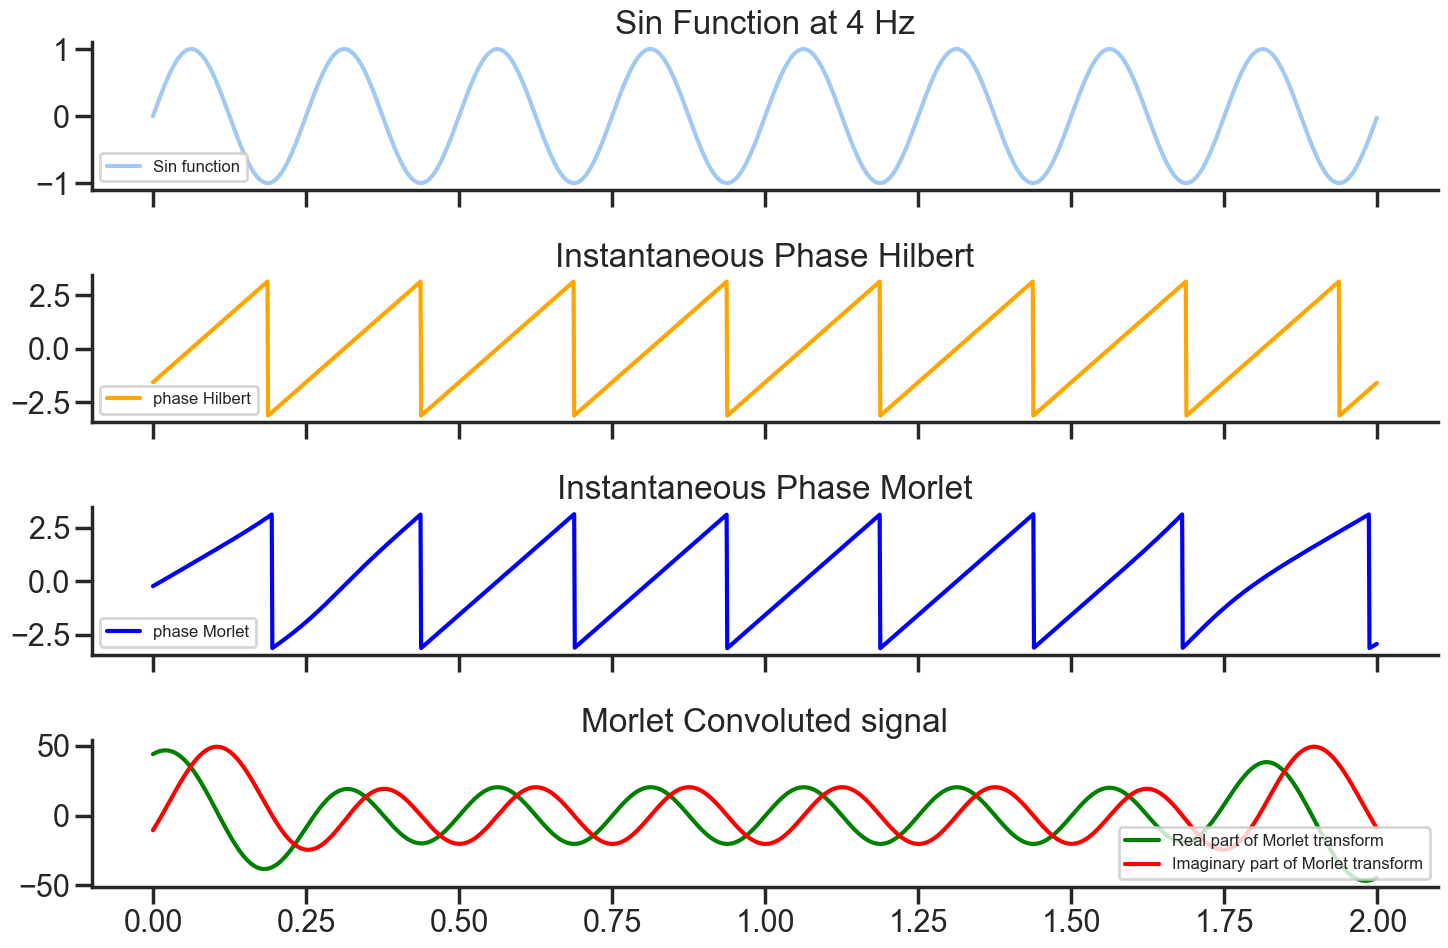

In [240]:
from scipy.signal import morlet, hilbert

# Generate a sin function at 4 Hz
sin_wave = np.sin(2 * np.pi * f * t)

# Compute the Morlet wavelet transform (a complex representation)
# widths = np.arange(1, 31)
morlet_wave = morlet(N, w=2, s=1.0)  # w is the width parameter, s is the scaling factor
# morlet_wave = morlet(N, w=2*np.pi*f, s=7/(2*np.pi*f), complete=True)

# Convolve the Morlet wavelet with the sin wave to get the complex signal
morlet_transform = np.convolve(sin_wave, morlet_wave, mode='same')
# Extract the instantaneous phase using Morlet transform
phase_morlet = np.angle(morlet_transform)

# Extract the instantaneous phase using Hilbert transform
analytic_signal = hilbert(sin_wave)
phase_hilbert = np.angle(analytic_signal)

# Plot the sin function, the phase, and the Morlet transform
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.set_size_inches(15, 10)

# Sin function
axs[0].plot(t, sin_wave, label='Sin function')
axs[0].set_title('Sin Function at 4 Hz')
axs[0].legend(fontsize=12)

# Instantaneous phase Hilbert 
axs[1].plot(t, phase_hilbert, label='phase Hilbert', color='orange')
axs[1].set_title('Instantaneous Phase Hilbert')
axs[1].legend(fontsize=12)

# Instantaneous phase Morlet
axs[2].plot(t, phase_morlet, label='phase Morlet', color='blue')
axs[2].set_title('Instantaneous Phase Morlet')
axs[2].legend(fontsize=12)

# Morlet transform
axs[3].plot(t, morlet_transform.real, label='Real part of Morlet transform', color='green')
axs[3].plot(t, morlet_transform.imag, label='Imaginary part of Morlet transform', color='red')
axs[3].set_title('Morlet Convoluted signal')
axs[3].legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


#### frequency in logscale for spike-LFP analysis

In [4]:
# frequency range values 
freq = np.logspace(0.32, 2, num=15, endpoint=True)
freq

array([  2.08929613,   2.7542287 ,   3.63078055,   4.78630092,
         6.30957344,   8.31763771,  10.96478196,  14.45439771,
        19.05460718,  25.11886432,  33.11311215,  43.65158322,
        57.54399373,  75.8577575 , 100.        ])

In [5]:
sampling_frequency = 1000  # in Hz
duration = 2  # in seconds
frequencies = [5, 10, 20, 40]  # Frequencies of the sine components in Hz

# Time array
t = np.arange(0, duration, 1/sampling_frequency)
t.size

2000

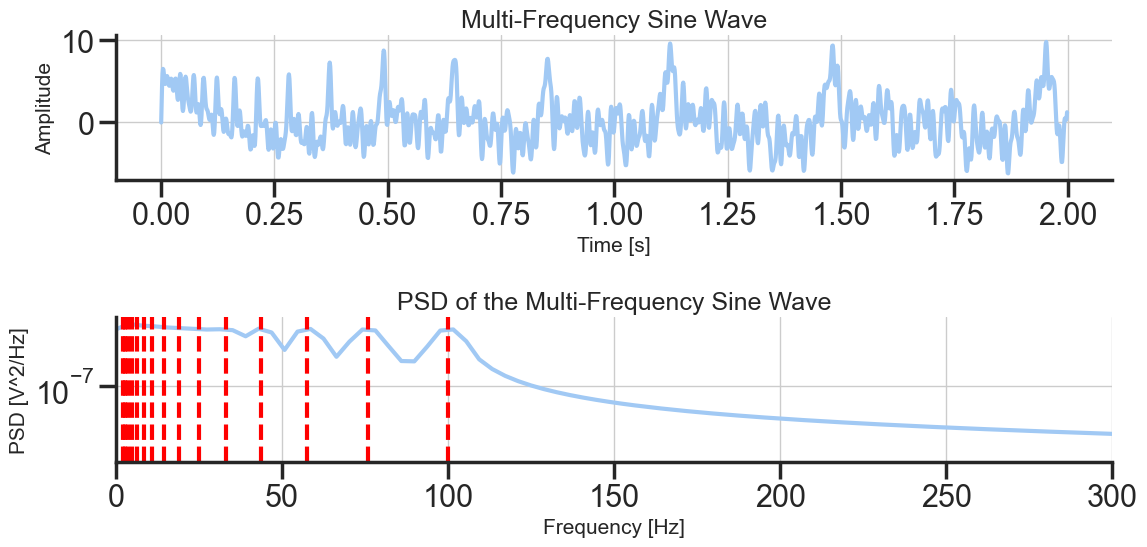

(2000, 2000)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sampling_frequency = 1000  # in Hz
duration = 2  # in seconds

# Frequencies of the sin functions
# freq = [4, 10, 20, 40]  # in Hz

# Calculate the number of samples for 4 full oscillations for each frequency
# samples_per_frequency = [int(4 * (1 / f) * fs) for f in frequencies]
# samples_per_frequency = [int(4 * (1 / f) * fs) for f in freq]
# # Take the maximum to ensure all frequencies complete 4 oscillations
# N = max(samples_per_frequency)
# # # Time vector for N time points
# t2 = np.arange(N) / fs

t2 = np.arange(0, duration, 1/sampling_frequency)

# Generate the combined sinusoidal function as the sum of three sin functions
# combined_sin_wave = sum([np.sin(2 * np.pi * f * t) for f in frequencies])
combined_sin_wave2 = sum(np.sin(2 * np.pi * f * t2) for f in freq)

frequencies_psd, psd = welch(combined_sin_wave2, fs=sampling_frequency, nperseg=256)


# Plot the combined sinusoidal function
# plt.figure(figsize=(12, 6))
# plt.plot(combined_sin_wave2, label='Combined Sinusoidal Function')
# plt.title('Combined Sinusoidal Function')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.legend(loc='upper right',fontsize=10)
# plt.show()

plt.figure(figsize=(12, 6))

# Sine wave plot
plt.subplot(2, 1, 1)
plt.plot(t2, combined_sin_wave2)
plt.title('Multi-Frequency Sine Wave',fontsize=18)
plt.xlabel('Time [s]',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.grid(linewidth=1)

# PSD plot
plt.subplot(2, 1, 2)
plt.semilogy(frequencies_psd, psd)
plt.title('PSD of the Multi-Frequency Sine Wave',fontsize=18)
plt.xlabel('Frequency [Hz]',fontsize=15)
plt.ylabel('PSD [V^2/Hz]',fontsize=15)
for f in freq:
    plt.axvline(x=f, color='r', linestyle='--', label='{} Hz'.format(int(f)))
# plt.legend()
plt.xlim([0,300])
plt.grid(linewidth=1)

plt.tight_layout()
plt.show()

t2.size, combined_sin_wave2.size

In [11]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.signal import morlet

# Bandpass filter design
def bandpass_filter(data, lowcut, highcut, sampling_rate, order=5):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Extract instantaneous phase with Hilbert transform
def instantaneous_phase_hilbert(signal, lowcut, highcut, sampling_freq):
    filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_freq)
    analytic_signal = hilbert(filtered_signal)
    instantaneous_phase = np.angle(analytic_signal)
    return instantaneous_phase

def instantaneous_phase_wavelet(signal, width, scale, frequency):
    # Generate Morlet wavelet
    w = morlet(M=len(signal), w=(2*np.pi*frequency), s=7/(2*np.pi*frequency), complete=True)
    wavelet = morlet(M=len(signal), w=width, s=scale)  # w is the width parameter, s is the scaling factor
    # Convolve signal with wavelet
    convolution = convolve(signal, wavelet, 'same')
    # Extract instantaneous phase
    instantaneous_phase = np.angle(convolution)
    return instantaneous_phase, wavelet, convolution

def instantaneous_phase_wavelet_cycles(signal, frequency, num_cycles, sampling_freq):

    # Compute the wavelet length
    sigma = num_cycles / (2 * np.pi * frequency)
    t = np.arange(-3.5*sigma, 3.5*sigma, 1/sampling_freq)
    wavelet = np.exp(2j * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
    
    # Convolve signal with wavelet
    convolution = convolve(signal, wavelet, 'same')
    # Extract instantaneous phase
    instantaneous_phase = np.angle(convolution)
    
    return instantaneous_phase, wavelet, convolution, t

freq 8.317637711026709 width 4


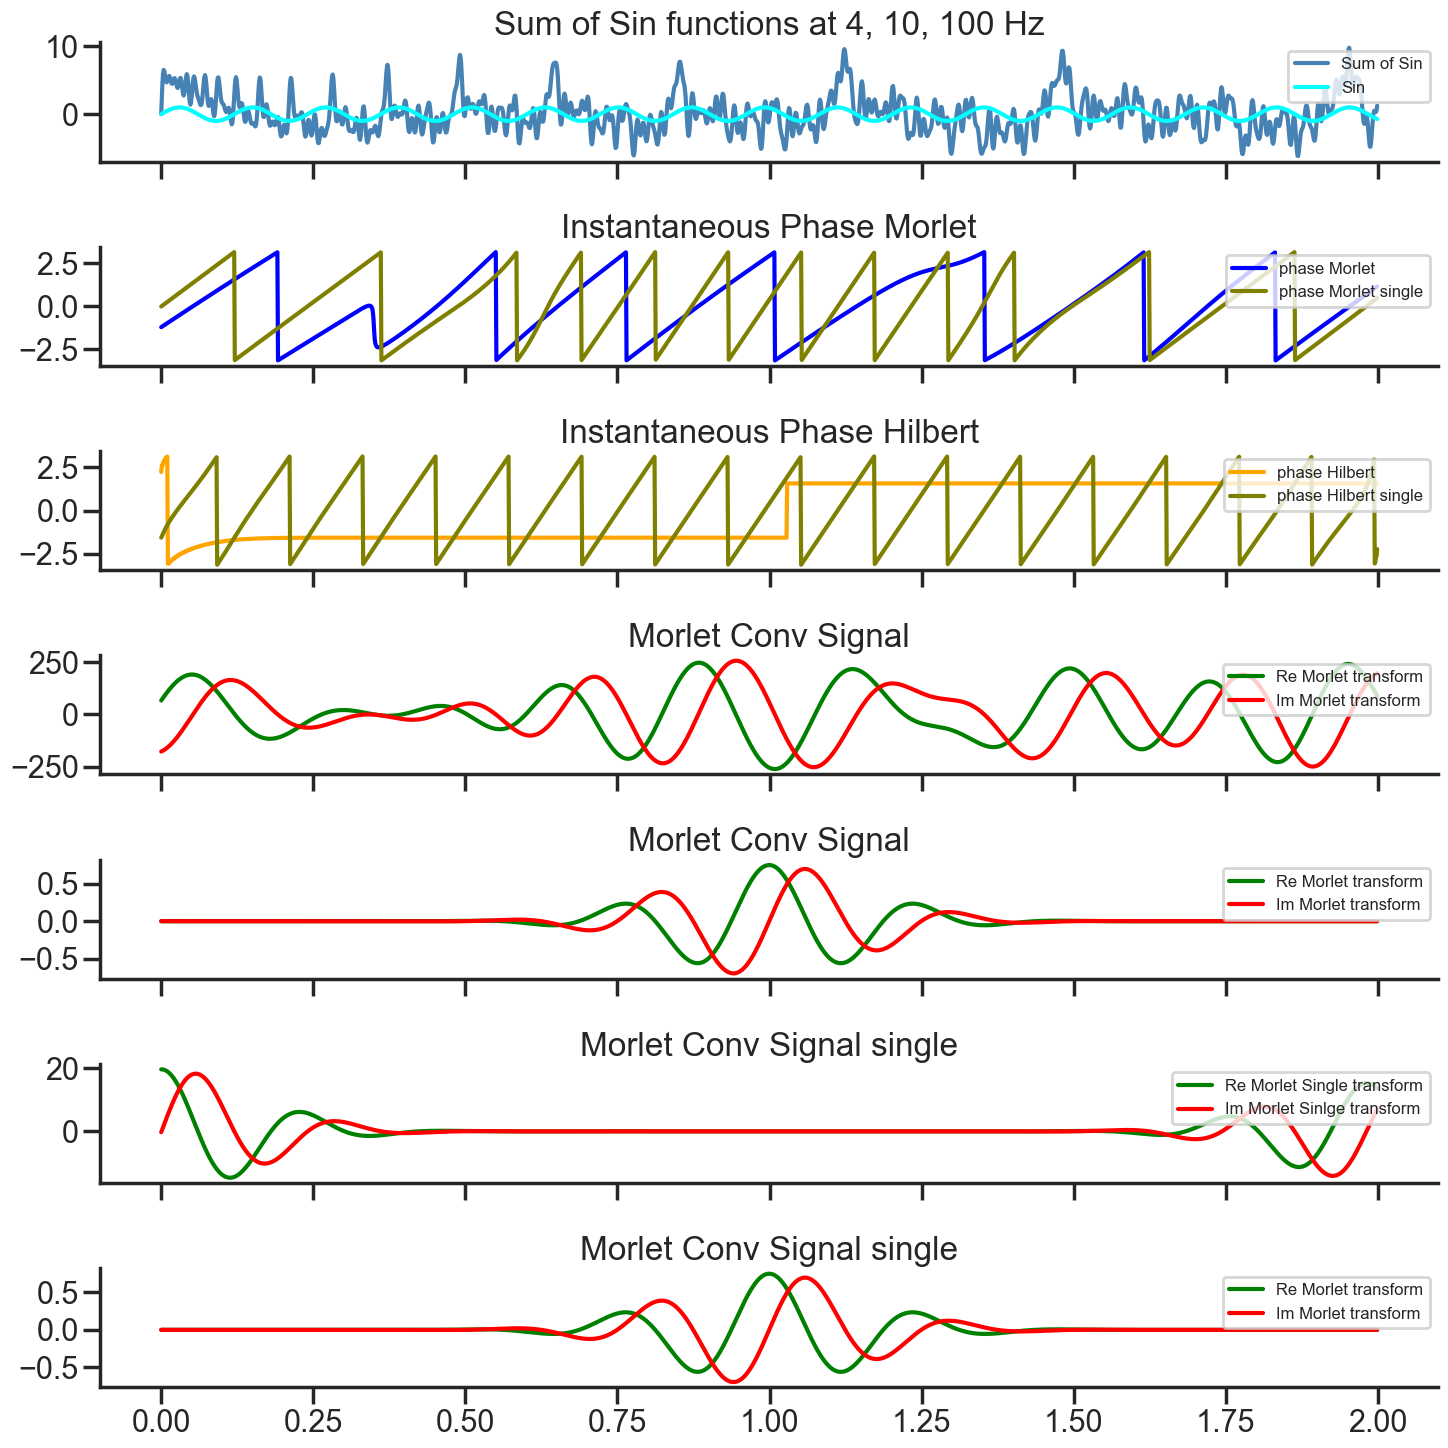

In [12]:
fs = 1000
f = freq[5]
scale = 1
width = int(f/2)

combined_sin_wave = combined_sin_wave2[0:]
t = t2[0:]

print('freq',f,'width',width)
# Combined Sin function 
phase_hilbert = instantaneous_phase_hilbert(combined_sin_wave, 3.5, 4.5, fs)
phase_morlet, wavelet_morlet, convolution_morlet = instantaneous_phase_wavelet(combined_sin_wave, width, scale, f)

# single Sin function 

sin_wave = np.sin(2 * np.pi * f * t)
# Morlet
wavelet_single = morlet(M=len(sin_wave), w= width, s=scale)  # w is the width parameter, s is the scaling factor
convolution_single = np.convolve(sin_wave, wavelet_single, mode='same')
phase_morlet_single = np.angle(convolution_single)

# Hilbert 
analytic_signal = hilbert(sin_wave)
phase_hilbert_single = np.angle(analytic_signal)


# Plot the sin function, the phase, and the Morlet transform
fig, axs = plt.subplots(7, 1, figsize=(14, 10), sharex=True)
fig.set_size_inches(15, 15)

# Sin function
axs[0].plot(t, combined_sin_wave, label='Sum of Sin',color='steelblue')
axs[0].plot(t, sin_wave, label='Sin',color='aqua')
axs[0].set_title('Sum of Sin functions at 4, 10, 100 Hz')
axs[0].legend(fontsize=12, loc='upper right')

# Instantaneous phase Morlet
axs[1].plot(t, phase_morlet, label='phase Morlet', color='blue')
axs[1].plot(t, phase_morlet_single, label='phase Morlet single', color='olive')
axs[1].set_title('Instantaneous Phase Morlet')
axs[1].legend(fontsize=12, loc='upper right')


# Instantaneous phase Hilbert 
axs[2].plot(t, phase_hilbert, label='phase Hilbert', color='orange')
axs[2].plot(t, phase_hilbert_single, label='phase Hilbert single', color='olive')
axs[2].set_title('Instantaneous Phase Hilbert')
axs[2].legend(fontsize=12, loc='upper right')

# Morlet convolution 
axs[3].plot(t, convolution_morlet.real, label='Re Morlet transform', color='green')
axs[3].plot(t, convolution_morlet.imag, label='Im Morlet transform', color='red')
axs[3].set_title('Morlet Conv Signal')
axs[3].legend(fontsize=12, loc='upper right')

# Morlet wavelet  
axs[4].plot(t, wavelet_morlet.real, label='Re Morlet transform', color='green')
axs[4].plot(t, wavelet_morlet.imag, label='Im Morlet transform', color='red')
axs[4].set_title('Morlet Conv Signal')
axs[4].legend(fontsize=12, loc='upper right')

# Morlet convolution Single
axs[5].plot(t, convolution_single.real, label='Re Morlet Single transform', color='green')
axs[5].plot(t, convolution_single.imag, label='Im Morlet Sinlge transform', color='red')
axs[5].set_title('Morlet Conv Signal single')
axs[5].legend(fontsize=12, loc='upper right')

# Morlet wavelet Single
axs[6].plot(t, wavelet_single.real, label='Re Morlet transform', color='green')
axs[6].plot(t, wavelet_single.imag, label='Im Morlet transform', color='red')
axs[6].set_title('Morlet Conv Signal single')
axs[6].legend(fontsize=12, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

t size 743


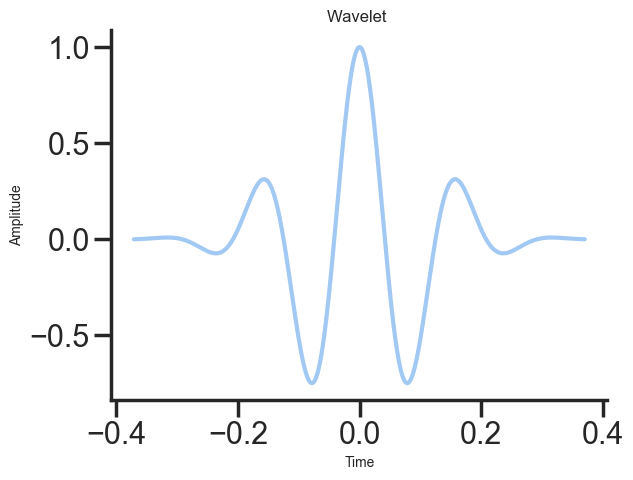

In [14]:
frequency = 6
num_cycles = 4
sampling_rate = 1000
sigma = num_cycles / (2 * np.pi * frequency)
t = np.arange(-3.5*sigma, 3.5*sigma, 1/sampling_rate)
# t = np.arange(-duration/2, duration/2, 1/sampling_rate)
wavelet = np.exp(2j * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
print('t size', t.size)

plt.plot(t, wavelet)
plt.title('Wavelet ',fontsize=12)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Amplitude',fontsize=10)
# plt.legend(fontsize=12, loc='upper right')
# plt.xlim([0,100])
plt.show()

In [419]:
# Compute the PSD using the Multitaper method
# psd, psd_f = mne.time_frequency.psd_array_multitaper(sin_wave, sfreq=fs, adaptive=True, normalization='full', verbose=0)

In [420]:
t.size, combined_sin_wave.size, sin_wave.size, phase_morlet_C.size

(558, 2000, 2000, 2000)

In [62]:
freq[14]

100.0

freq 100.0 width 50.0 scale 1


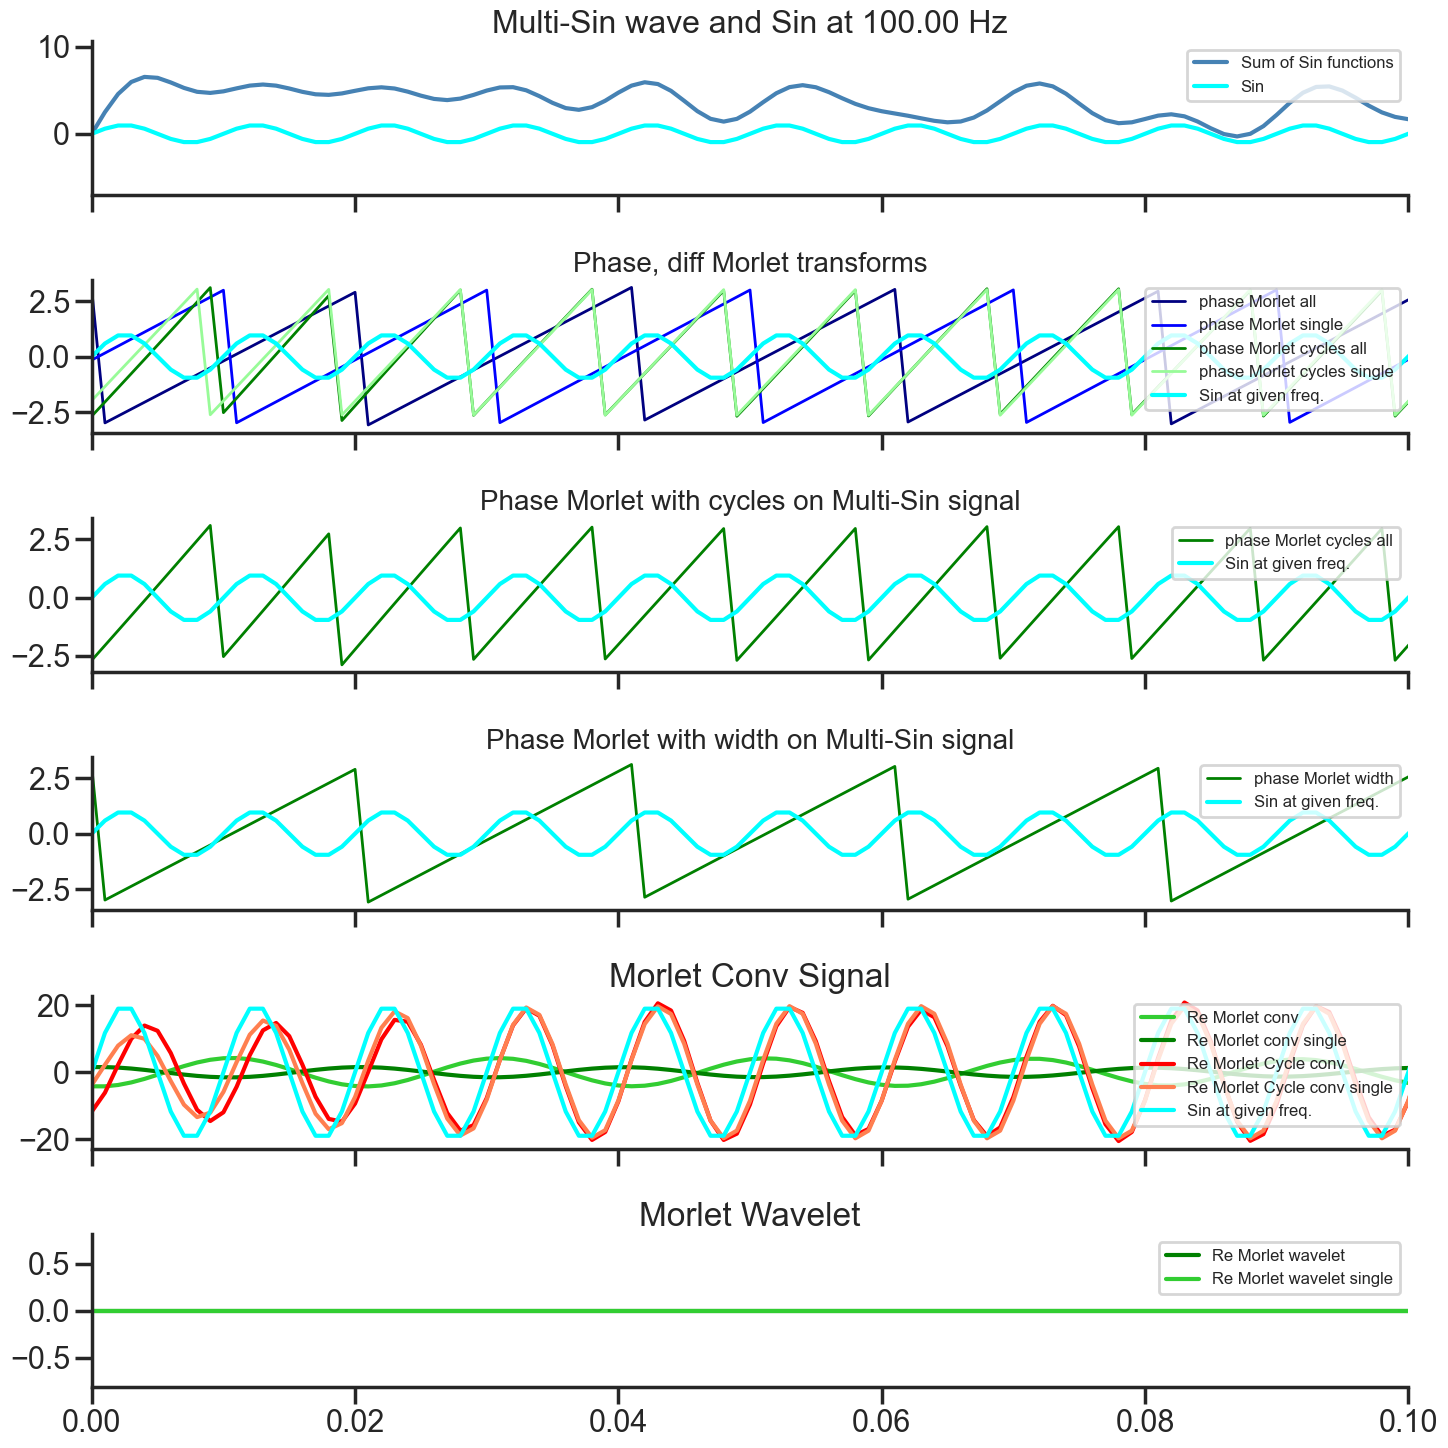

In [71]:
fs = 1000
f = freq[14]
scale = 1
width = f/2
n = 10 # number of cycles

print('freq',f,'width',width,'scale',scale)

"""  For Multi-Wave Signal  """

# Combined Sin function 
combined_sin_wave = combined_sin_wave2[0:]
t = t2[0:]

# Phase with Hilbert tranform 
phase_hilbert = instantaneous_phase_hilbert(combined_sin_wave, 3.5, 4.5, fs)
# Morlet: phase, wavelet, convolution --- for the function with width and scale 
phase_morlet, wavelet_morlet, convolution_morlet = instantaneous_phase_wavelet(combined_sin_wave, width, scale, f)
# Morlet: phase, wavelet, convolution --- for the function n cycles 
phase_morlet_C, wavelet_morlet_C, convolution_morlet_C, time_C = instantaneous_phase_wavelet_cycles(combined_sin_wave, f, n, fs)

""" For Single Sin function """

# single Sin function 
sin_wave = np.sin(2 * np.pi * f * t)

# Phase with Hilbert tranform  
analytic_signal = hilbert(sin_wave)
phase_hilbert_single = np.angle(analytic_signal)
# Morlet: phase, wavelet, convolution --- for the function with width and scale 
wavelet_single = morlet(M=len(sin_wave), w= width, s=scale)  # w is the width parameter, s is the scaling factor
convolution_single = convolve(sin_wave, wavelet_single, mode='same')
phase_morlet_single = np.angle(convolution_single)
# Morlet: phase, wavelet, convolution --- for the function n cycles 
phase_morlet_C_single, wavelet_morlet_C_single, convolution_morlet_C_single, time_C_single = instantaneous_phase_wavelet_cycles(sin_wave, f, n, fs)


""" Plot Figure """

# Plot the sin function, the phase, and the Morlet transform
fig, axs = plt.subplots(6, 1, figsize=(14, 10), sharex=True)
fig.set_size_inches(15, 15)

# Sin function
axs[0].set_title('Multi-Sin wave and Sin at {:.2f} Hz'.format(f), fontsize=23)
axs[0].plot(t, combined_sin_wave, label='Sum of Sin functions',color='steelblue')
axs[0].plot(t, sin_wave, label='Sin',color='aqua')
axs[0].legend(fontsize=12, loc='upper right')

# Instantaneous phase Morlet
axs[1].set_title('Phase, diff Morlet transforms', fontsize=20)
axs[1].plot(t, phase_morlet, label='phase Morlet all', color='navy', linewidth=2)
axs[1].plot(t, phase_morlet_single, label='phase Morlet single', color='blue', linewidth=2)
axs[1].plot(t, phase_morlet_C, label='phase Morlet cycles all', color='g', linewidth=2)
axs[1].plot(t, phase_morlet_C_single, label='phase Morlet cycles single', color='palegreen', linewidth=2)
# axs[1].plot(t, phase_hilbert_single, label='phase Hilbert single', color='tan')
axs[1].plot(t, sin_wave, label='Sin at given freq.',color='aqua')
axs[1].legend(fontsize=12, loc='upper right')

# Instantaneous phase Morlet
axs[2].set_title('Phase Morlet with cycles on Multi-Sin signal', fontsize=20)
axs[2].plot(t, phase_morlet_C, label='phase Morlet cycles all', color='g', linewidth=2)
axs[2].plot(t, sin_wave, label='Sin at given freq.',color='aqua')
axs[2].legend(fontsize=12, loc='upper right')

# Instantaneous phase Morlet
axs[3].set_title('Phase Morlet with width on Multi-Sin signal', fontsize=20)
axs[3].plot(t, phase_morlet, label='phase Morlet width', color='g', linewidth=2)
axs[3].plot(t, sin_wave, label='Sin at given freq.',color='aqua')
axs[3].legend(fontsize=12, loc='upper right')

# # Instantaneous phase Hilbert 
# axs[3].plot(t, phase_hilbert, label='phase Hilbert', color='orange')
# axs[3].plot(t, phase_hilbert_single, label='phase Hilbert single', color='tan')
# axs[3].set_title('Instantaneous Phase Hilbert')
# axs[3].legend(fontsize=12, loc='upper right')

# Morlet convolution 
axs[4].plot(t, convolution_morlet.real, label='Re Morlet conv ', color='limegreen')
axs[4].plot(t, convolution_single.real, label='Re Morlet conv single', color='g')
axs[4].plot(t, convolution_morlet_C.real, label='Re Morlet Cycle conv', color='red')
axs[4].plot(t, convolution_morlet_C_single.real, label='Re Morlet Cycle conv single', color='coral')
axs[4].plot(t, 20*sin_wave, label='Sin at given freq.',color='aqua')
axs[4].set_title('Morlet Conv Signal')
axs[4].legend(fontsize=12, loc='upper right')

# Morlet wavelet  
axs[5].plot(t, wavelet_morlet.real, label='Re Morlet wavelet', color='green')
axs[5].plot(t, wavelet_single.real, label='Re Morlet wavelet single', color='limegreen')
# axs[4].plot(t, wavelet_morlet_C.real, label='Re Morlet wavelet Cycles', color='red')
# axs[4].plot(t, wavelet_morlet_C_single.real, label='Re Morlet wavelet Cycles single', color='olive')
axs[5].set_title('Morlet Wavelet')
axs[5].legend(fontsize=12, loc='upper right')

plt.xlim([0, 0.1])
# Adjust layout
plt.tight_layout()
plt.show()

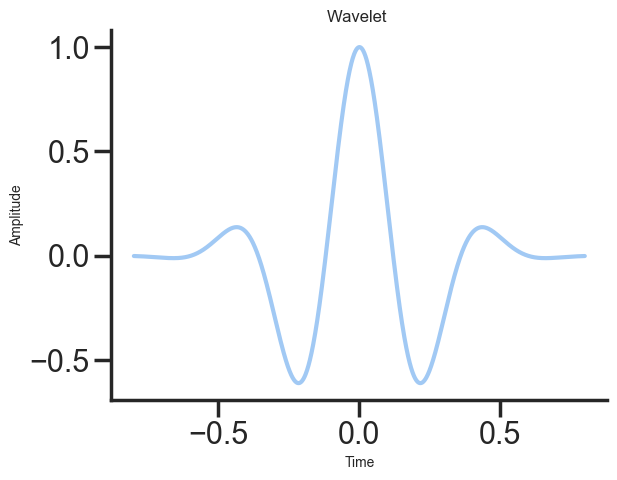

In [29]:
phase_morlet_C_single, wavelet_morlet_C_single, convolution_morlet_C_single, time_C = instantaneous_phase_wavelet_cycles(sin_wave, f, n, fs)

plt.plot(time_C,wavelet_morlet_C_single.real)
plt.title('Wavelet ',fontsize=12)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Amplitude',fontsize=10)
# plt.legend(fontsize=12, loc='upper right')
# plt.xlim([0,100])
plt.show()

In [31]:
f

2.0892961308540396

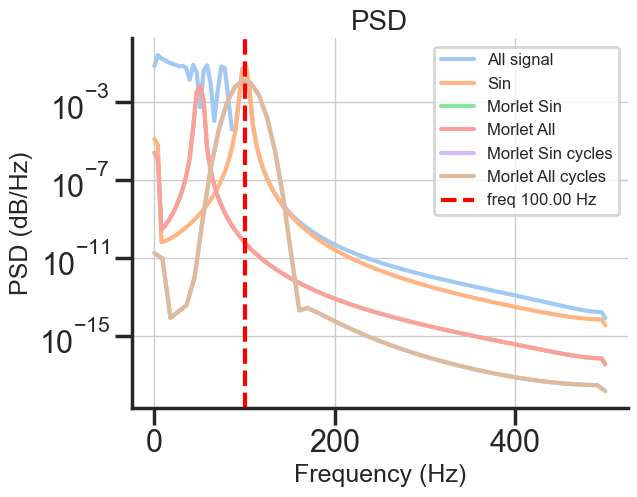

In [73]:
# PSD of sin
f_max = 2000
nump = 256
# PSD of Wave functions
psd_f_single, psd_single = welch(sin_wave, fs=1000, nperseg=nump)
psd_f, psd = welch(combined_sin_wave, fs=1000, nperseg=nump)
# PSD of Morlet transforms 
psd_f_morlet_single, psd_morlet_single = welch(wavelet_single.real, fs=1000, nperseg=nump) # sin function morlet width
psd_f_morlet, psd_morlet = welch(wavelet_morlet.real, fs=1000, nperseg=nump) # sin function morlet width
psd_f_morlet_C_single, psd_morlet_C_single = welch(wavelet_morlet_C_single.real, fs=1000, nperseg=nump) # sin function morlet cycle
psd_f_morlet_C, psd_morlet_C = welch(wavelet_morlet_C.real, fs=1000, nperseg=nump) # all functions morlet cycles 

plt.semilogy(psd_f, psd)
plt.semilogy(psd_f_single, psd_single)
plt.semilogy(psd_f_morlet_single, psd_morlet_single)
plt.semilogy(psd_f_morlet, psd_morlet)
plt.semilogy(psd_f_morlet_C_single, psd_morlet_C_single)
plt.semilogy(psd_f_morlet_C, psd_morlet_C)
plt.axvline(x=f, color='r', linestyle='--', label='Peak at {} Hz'.format(int(f)))
# plt.plot(psd_f, 10 * np.log10(psd))
plt.title('PSD',fontsize=20)
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('PSD (dB/Hz)',fontsize=18)
plt.legend(['All signal','Sin','Morlet Sin','Morlet All','Morlet Sin cycles','Morlet All cycles','freq {:.2f} Hz'.format(f)],fontsize=12, loc='upper right')
# for f in freq:
#     plt.axvline(x=f, color='r', linestyle='--', label='{} Hz'.format(int(f)))
# plt.legend(fontsize=12,loc='upper right')

# plt.xlim([0,100])
plt.grid(linewidth=1)

plt.show()